# Notes on Chapter 4 of *Hands-On Machine Learning with Scikit-Learn, Keras, & TensorFlow* by Aurélien Géron

## Linear regression

In [1]:
import numpy as np
from matplotlib import pyplot as plt

In [2]:
np.random.seed(1811)

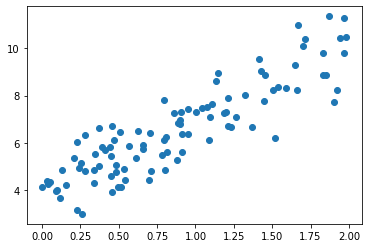

In [3]:
X = 2*np.random.rand(100,1)
X_aug = np.c_[X, np.ones(len(X))]

theta = np.array([3,4])
y = X_aug.dot(theta) + np.random.normal(size=(X.shape[0]))
plt.scatter(X[:,0], y)

Solve using the normal equation

In [4]:
theta_hat = np.linalg.inv(X_aug.T.dot(X_aug)).dot(X_aug.T).dot(y)
theta_hat

array([3.05371062, 3.88601208])

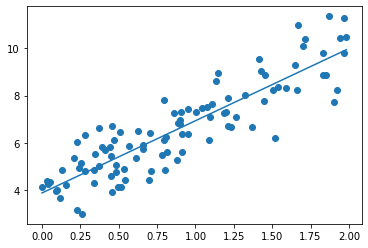

In [5]:
plt.scatter(X[:,0], y)
plt.plot([min(X), max(X)], theta_hat.dot(np.c_[[min(X), 1], [max(X), 1]]))

Solve using sklearn...

In [6]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(X, y)
lin_reg.coef_, lin_reg.intercept_

(array([3.05371062]), 3.8860120754449277)

...which uses numpy's least squares...

In [7]:
svd, residuals, rank, s = np.linalg.lstsq(X_aug, y, rcond=1e-6)
svd

array([3.05371062, 3.88601208])

...which uses the Moore--Penrose inverse.

In [8]:
np.linalg.pinv(X_aug).dot(y)

array([3.05371062, 3.88601208])

Batch gradient descent:

In [9]:
eta = 0.005 # learning rate
max_iter = 1000

theta_hat = np.random.normal(size=X_aug.shape[1])
for i in range(max_iter):
    grad = 2/X_aug.shape[1] * X_aug.T.dot(X_aug.dot(theta_hat) - y)
    theta_hat = theta_hat - eta * grad

theta_hat

array([3.05371062, 3.88601208])

Stochastic gradient descent:

In [10]:
max_epochs = 1000
eta0 = 0.1
t0 = 100

def learning_schedule(t):
    return eta0 * t0 / (t + t0)

theta_hat = np.random.normal(size=X_aug.shape[1])

for epoch in range(max_epochs):
    for i in range(X_aug.shape[0]):
        j = np.random.randint(X_aug.shape[0])
        grad = 2 * X_aug[j].dot(X_aug[j].dot(theta_hat) - y[j])
        eta = learning_schedule(epoch * X_aug.shape[0] + i)
        theta_hat = theta_hat - eta * grad
        
theta_hat

array([3.03768816, 3.88182368])

In [15]:
from sklearn.linear_model import SGDRegressor

sgd = SGDRegressor(max_iter=1000, tol=1e-3, penalty=None, eta0=0.1)
sgd.fit(X, y)
sgd.coef_, sgd.intercept_

(array([3.01701198]), array([3.81808463]))

Minibatch gradient descent:

In [35]:
max_epochs = 1000
batch_size = 10
eta0 = 0.1
t0 = 50

def learning_schedule(t):
    return eta0 * t0 / (t + t0)

theta_hat = np.random.normal(size=X_aug.shape[1])

for epoch in range(max_epochs):
    for batch in range(int(X_aug.shape[0]/batch_size)):
        i_batch = np.random.choice(X_aug.shape[0], batch_size, replace=False)
        X_batch = X_aug[i_batch]
        y_batch = y[i_batch]
        grad = 2/X_batch.shape[1] * X_batch.T.dot(X_batch.dot(theta_hat) - y_batch)
        eta = learning_schedule(epoch * X_aug.shape[0] + batch * batch_size)
        theta_hat = theta_hat - eta * grad
        
theta_hat

array([3.05459857, 3.88064258])

Polynomial regression

Start by generating a non-linear dataset:

In [115]:
m = 100
X = 6 * np.random.rand(m,1) - 3
y = (0.5 * X**2 + X + 2 + 0.5 * np.random.randn(m,1))[:,0]

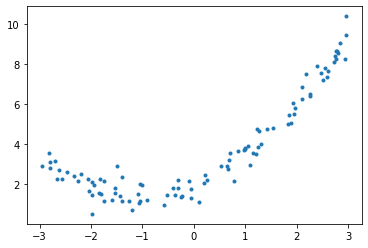

In [116]:
plt.plot(X, y, '.')

In [117]:
from sklearn.preprocessing import PolynomialFeatures
poly_features = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly_features.fit_transform(X)

In [118]:
X[:3], X_poly[:3]

(array([[ 1.41945607],
        [-2.33082308],
        [ 2.76966472]]),
 array([[ 1.41945607,  2.01485554],
        [-2.33082308,  5.43273624],
        [ 2.76966472,  7.67104268]]))

In [119]:
lm = LinearRegression()
lm.fit(X_poly, y)
lm.intercept_, lm.coef_

(1.960701990333335, array([1.0181381 , 0.49311835]))

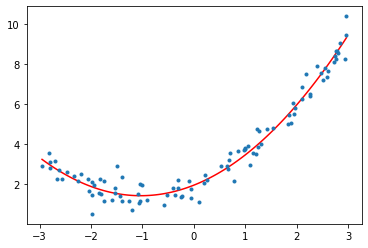

In [120]:
x_linear = np.linspace(min(X), max(X), 100)

plt.plot(x_linear, lm.predict(poly_features.transform(x_linear)), 'r')
plt.plot(X, y, '.')

Learning curves

In [123]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

def plot_learning_curves(m, X, y):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)
    train_errors = []
    val_errors = []
    for N in range(1, X_train.shape[0]):
        m.fit(X_train[:N], y_train[:N])
        y_hat_train = m.predict(X_train[:N])
        y_hat_val = m.predict(X_val)
        train_errors.append(mean_squared_error(y_hat_train, y_train[:N]))
        val_errors.append(mean_squared_error(y_hat_val, y_val))
    plt.plot(np.sqrt(train_errors), "r-+", label="train")
    plt.plot(np.sqrt(val_errors), "b-", label="val")
    plt.legend()

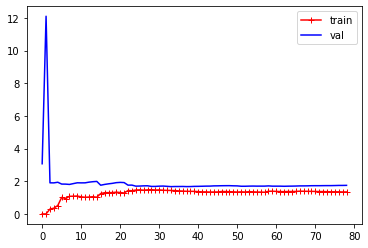

In [124]:
plot_learning_curves(LinearRegression(), X, y)

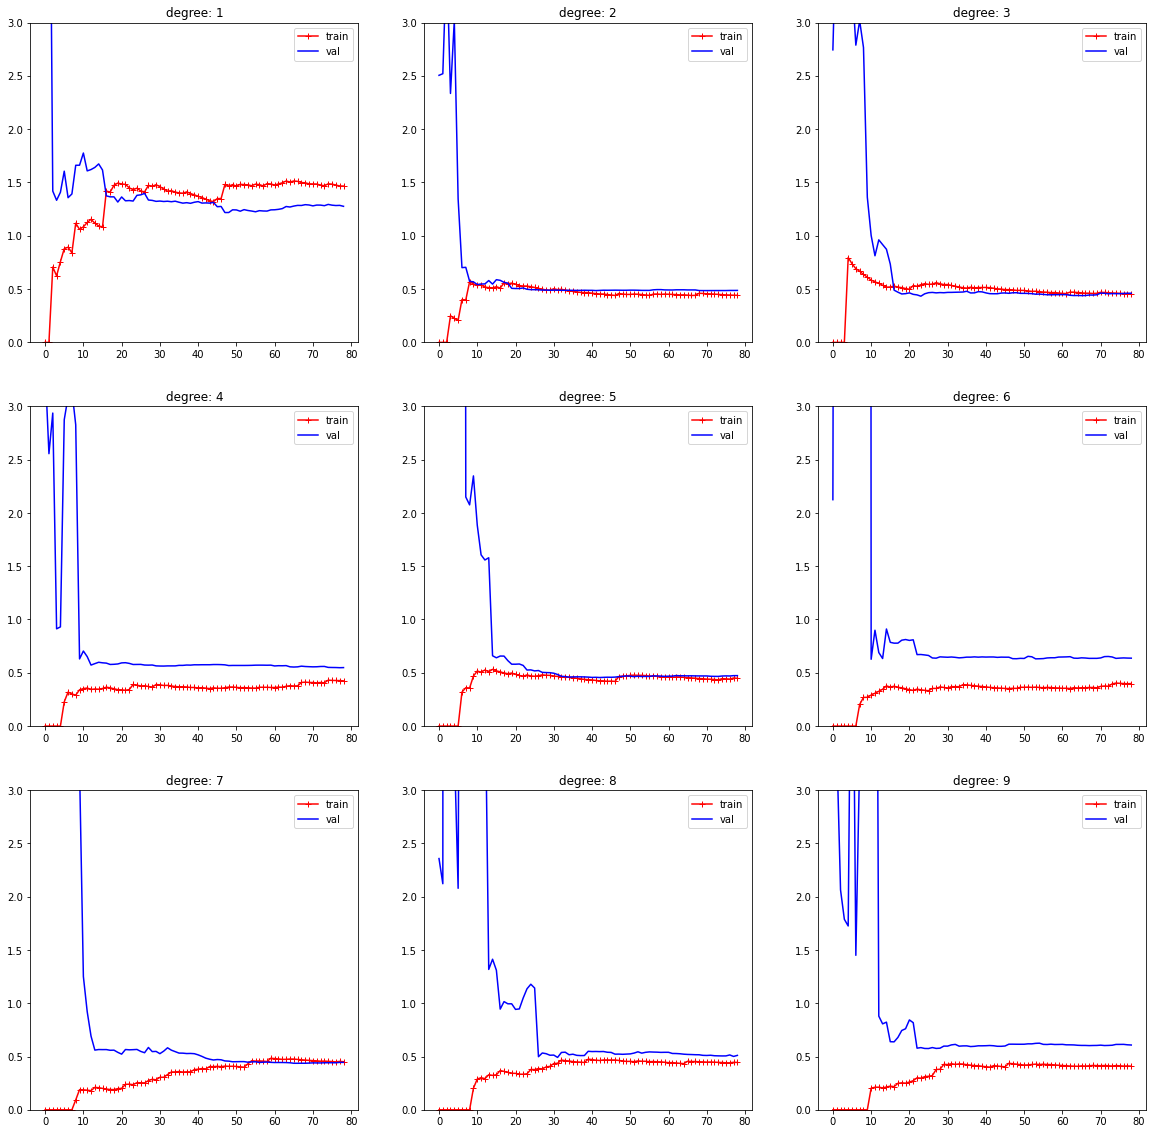

In [136]:
from sklearn.pipeline import Pipeline

numplots = 9
numcols = 3
plt.subplots(figsize=(20,20))
for i in range(numplots):
    ax = plt.subplot(numplots/numcols, numcols, i+1)
    plot_learning_curves(Pipeline([
        ("poly", PolynomialFeatures(degree=i+1, include_bias=False)),
        ("lr", LinearRegression())
    ]), X, y)
    plt.ylim(0, 3)
    plt.title(f'degree: {i+1}')

Ridge regression can be performed via Cholesky decomposition...

In [137]:
from sklearn.linear_model import Ridge
ridge = Ridge(alpha=1, solver="cholesky")
ridge.fit(X, y)
ridge.predict([[1.5]])

array([5.28800648])

...and with stochastic gradient descent:

In [138]:
sgd = SGDRegressor(penalty="l2")
sgd.fit(X, y)
sgd.predict([[1.5]])

array([5.27814574])

Lasso also is available:

In [139]:
from sklearn.linear_model import Lasso
lasso = Lasso(alpha=0.1)
lasso.fit(X, y)
lasso.predict([[1.5]])

array([5.25140767])

...as are elastic nets:

In [141]:
from sklearn.linear_model import ElasticNet
en = ElasticNet(alpha=0.1, l1_ratio=0.5)
en.fit(X, y)
en.predict([[1.5]])

array([5.24933363])

Example implementation of early stopping:

In [143]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)

In [151]:
from sklearn.base import clone
from sklearn.preprocessing import StandardScaler

polyscaler = Pipeline([
    ('poly', PolynomialFeatures(degree=90, include_bias=False)),
    ('scaler', StandardScaler())
])
X_train_proc = polyscaler.fit_transform(X_train)
X_val_proc = polyscaler.transform(X_val)

sgd = SGDRegressor(max_iter=1, tol=-np.infty, warm_start=True, penalty=None, learning_rate='constant', eta0=0.0005)
min_error = np.infty
best_epoch = None
best_model = None
for epoch in range(1000):
    sgd.fit(X_train_proc, y_train)
    y_hat_val = sgd.predict(X_val_proc)
    val_error = mean_squared_error(y_val, y_hat_val)
    if val_error < min_error:
        min_error = val_error
        best_epoch = epoch
        best_model = clone(sgd)

min_error, val_error

(0.4190529096941583, 1.4253192672994246)

Load the Iris dataset

In [152]:
from sklearn import datasets

iris = datasets.load_iris()
list(iris.keys())

['data',
 'target',
 'frame',
 'target_names',
 'DESCR',
 'feature_names',
 'filename']

In [153]:
iris['feature_names']

['sepal length (cm)',
 'sepal width (cm)',
 'petal length (cm)',
 'petal width (cm)']

Fit a single class logistic regression model on the data.

In [163]:
from sklearn.linear_model import LogisticRegression

X = iris['data'][:, 3:] # petal width
y = (iris['target'] == 2).astype(np.int)
log_reg = LogisticRegression()
log_reg.fit(X,y);

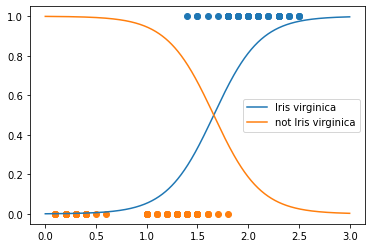

In [164]:
X_new = np.linspace(0, 3, 1000).reshape(-1, 1)
y_proba = log_reg.predict_proba(X_new)
plt.plot(X_new, y_proba[:,1], label="Iris virginica")
plt.plot(X_new, y_proba[:,0], label="not Iris virginica")
plt.scatter(X[y == 1], y[y==1])
plt.scatter(X[y == 0], y[y==0])
plt.legend()

Three class example:

In [168]:
X = iris['data'][:, 2:] # petal length and width
y = iris['target']
softmax_reg = LogisticRegression(multi_class='multinomial', solver='lbfgs', C=10)
softmax_reg.fit(X,y);
softmax_reg.predict_proba([[5,2]])

array([[6.38014896e-07, 5.74929995e-02, 9.42506362e-01]])

## Exercises